# Fair classifiers with adversarial networks

Gilles Louppe, 2017.

We illustrate how one can use adversarial networks for building a classifier whose output is forced to be independent of some chosen attribute. We follow the adversarial networks setup described in "Learning to Pivot with Adversarial Networks" (Louppe, Kagan and Cranmer, 2016, [arXiv:1611.01046](https://arxiv.org/abs/1611.01046)).

In this notebook, we will show more specifically how one can build a fair classifier whose decision is made independent of gender.

```
@article{louppe2016pivot,
           author = {{Louppe}, G. and {Kagan}, M. and {Cranmer}, K.},
            title = "{Learning to Pivot with Adversarial Networks}",
          journal = {ArXiv e-prints},
    archivePrefix = "arXiv",
           eprint = {1611.01046},
     primaryClass = "stat.ML",
             year = 2016,
            month = nov,
}
```

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

# Prepare data

We are using the [adult](https://archive.ics.uci.edu/ml/datasets/Adult) UCI dataset, where the prediction task is to predict whether someone makes over 50,000$ a year.

In [2]:
original_data = pd.read_csv(
    "adult.data.txt", 
    names=["Age", "Workclass", "fnlwgt", "Education", "Education-Num", 
           "Martial Status", "Occupation", "Relationship", "Race", "Sex", 
           "Capital Gain", "Capital Loss", "Hours per week", "Country", "Target"],
    sep=r'\s*,\s*', engine='python', na_values="?")
original_data.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
data = pd.get_dummies(original_data)
target = data["Target_>50K"].values
gender = data["Sex_Male"].values
del data["Target_<=50K"]
del data["Target_>50K"]

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test, gender_train, gender_test = train_test_split(data, target, gender, train_size=0.5, test_size=0.5)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Standard classifier

We first train a standard neural network on the training data.

In [5]:
import keras.backend as K
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD

inputs = Input(shape=(X_train.shape[1],))
Dx = Dense(32, activation="relu")(inputs)
Dx = Dense(32, activation="relu")(Dx)
Dx = Dense(32, activation="relu")(Dx)
Dx = Dense(1, activation="sigmoid")(Dx)
D = Model(inputs=[inputs], outputs=[Dx])
D.compile(loss="binary_crossentropy", optimizer="adam")

Using TensorFlow backend.


In [6]:
D.fit(X_train, y_train, epochs=10)

Epoch 1/10
16280/16280 [==============================] - 1s 31us/step - loss: 0.3863
Epoch 2/10
16280/16280 [==============================] - 0s 25us/step - loss: 0.3261
Epoch 3/10
16280/16280 [==============================] - 0s 27us/step - loss: 0.3121
Epoch 4/10
16280/16280 [==============================] - 0s 27us/step - loss: 0.3048
Epoch 5/10
16280/16280 [==============================] - 0s 27us/step - loss: 0.2990
Epoch 6/10
16280/16280 [==============================] - 0s 24us/step - loss: 0.2948
Epoch 7/10
16280/16280 [==============================] - 0s 24us/step - loss: 0.2909
Epoch 8/10
16280/16280 [==============================] - 0s 28us/step - loss: 0.2878
Epoch 9/10
16280/16280 [==============================] - 0s 28us/step - loss: 0.2836
Epoch 10/10
16280/16280 [==============================] - 0s 28us/step - loss: 0.2807


In [7]:
from sklearn.metrics import roc_auc_score
y_pred = D.predict(X_test)
roc_auc_score(y_test, y_pred)

0.9035161804281756

Performance is good, but as the plot below illustrates, the distribution of the classifier output is different depending on gender. In particular, the classifier models that women are less likely to make more than 50,000$ a year than men.

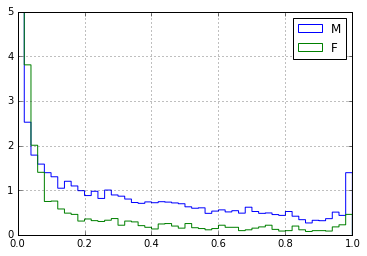

In [8]:
plt.hist(y_pred[gender_test == 1], bins=50, histtype="step",  normed=1, label="M")
plt.hist(y_pred[gender_test == 0], bins=50, histtype="step", normed=1, label="F")
plt.ylim(0, 5)
plt.legend()
plt.grid()
plt.show()

The pearson correlation coefficient between gender and the classifier output also clearly highlights this dependency.

In [9]:
from scipy.stats import pearsonr
pearsonr(gender_test, D.predict(X_test).ravel())

(0.3156376533782231, 0.0)

# Training with adversarial networks

Let us now jointly train our classifier with an adversarial network. The goal of this second network is to predict gender from the classifier output. If this network is doing well, then it clearly indicates that the classifier output is correlated with the attribute. Accordingly, one can force the classifier to distort its decision to make the adversarial network performs worse. This is the strategy we will use.

In [10]:
def make_trainable(network, flag):
    network.trainable = flag
    network.compile
    for l in network.layers:
        l.trainable = flag

inputs = Input(shape=(X_train.shape[1],))

Dx = Dense(32, activation="relu")(inputs)
Dx = Dense(32, activation="relu")(Dx)
Dx = Dense(32, activation="relu")(Dx)
Dx = Dense(1, activation="sigmoid")(Dx)
D = Model(inputs=[inputs], outputs=[Dx])

Rx = Dx
Rx = Dense(32, activation="relu")(Rx)
Rx = Dense(32, activation="relu")(Rx)
Rx = Dense(32, activation="relu")(Rx)
Rx = Dense(1, activation="sigmoid")(Rx)
R = Model(inputs=[inputs], outputs=[Rx])

In [11]:
lam = 10.0  # control the trade-off between classification performance and independence

def make_loss_D(c):
    def loss_D(y_true, y_pred):
        return c * K.binary_crossentropy(y_true, y_pred)
    return loss_D

def make_loss_R(c):
    def loss_R(z_true, z_pred):
        return c * K.binary_crossentropy(z_true, z_pred)
    return loss_R

opt_D = SGD()
D.compile(loss=[make_loss_D(c=1.0)], optimizer=opt_D)

opt_DRf = SGD(momentum=0.0)
DRf = Model(inputs=[inputs], outputs=[D(inputs), R(inputs)])
make_trainable(R, False)
make_trainable(D, True)
DRf.compile(loss=[make_loss_D(c=1.0), make_loss_R(c=-lam)], optimizer=opt_DRf)

opt_DfR = SGD(momentum=0.0)
DfR = Model(inputs=[inputs], outputs=[R(inputs)])
make_trainable(R, True)
make_trainable(D, False)
DfR.compile(loss=[make_loss_R(c=1.0)], optimizer=opt_DfR)

In [12]:
from keras.utils.vis_utils import plot_model
plot_model(D, to_file='png/D_model.png')
plot_model(R, to_file='png/R_model.png')
plot_model(DRf, to_file='png/DRf_model.png')
plot_model(DfR, to_file='png/DfR_model.png')

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

In [ ]:
# Pretraining of D
make_trainable(R, False)
make_trainable(D, True)
D.fit(X_train, y_train, epochs=10)

In [ ]:
# Pretraining of R
make_trainable(R, True)
make_trainable(D, False)
DfR.fit(X_train, gender_train, epochs=10)

In [ ]:
def plot_losses(i, losses):
    display.clear_output(wait=True)
    display.display(plt.gcf())

    ax1 = plt.subplot(311)   
    values = np.array(losses["L_f"])
    plt.plot(range(len(values)), values, label=r"$L_f$", color="blue")
    plt.legend(loc="upper right")
    plt.grid()
    
    ax2 = plt.subplot(312, sharex=ax1) 
    values = np.array(losses["L_r"]) / lam
    plt.plot(range(len(values)), values, label=r"$L_r$", color="green")
    plt.legend(loc="upper right")
    plt.grid()
    
    ax3 = plt.subplot(313, sharex=ax1)
    values = np.array(losses["L_f - L_r"])
    plt.plot(range(len(values)), values, label=r"$L_f - \lambda L_r$", color="red")  
    plt.legend(loc="upper right")
    plt.grid()
    
    plt.show()  

In [ ]:
losses = {"L_f": [], "L_r": [], "L_f - L_r": []}

In [ ]:
batch_size = 128

for i in range(201):
    l = DRf.evaluate(X_test, [y_test, gender_test], verbose=0)    
    losses["L_f - L_r"].append(l[0][None][0])
    losses["L_f"].append(l[1][None][0])
    losses["L_r"].append(-l[2][None][0])
    print(losses["L_r"][-1] / lam, losses["L_f"][-1], losses["L_f - L_r"][-1])
    
    if i % 10 == 0:
        plot_losses(i, losses)

    # Fit D
    make_trainable(R, False)
    make_trainable(D, True)
    indices = np.random.permutation(len(X_train))[:batch_size]
    DRf.train_on_batch(X_train[indices], [y_train[indices], gender_train[indices]])
    
    # Fit R
    make_trainable(R, True)
    make_trainable(D, False)
    DfR.fit(X_train, gender_train, batch_size=batch_size, epochs=1, verbose=1)

In [ ]:
y_pred = D.predict(X_test)
roc_auc_score(y_test, y_pred)

Performance is slightly worse, but as the plot and the pearson correlation coefficient show below, the distribution of the classifier output is now almost independent of gender. The classifier is now fair.

In [ ]:
plt.hist(y_pred[gender_test == 1], bins=50, histtype="step",  normed=1, label="M")
plt.hist(y_pred[gender_test == 0], bins=50, histtype="step", normed=1, label="F")
plt.ylim(0, 5)
plt.legend()
plt.grid()
plt.show()

In [ ]:
from scipy.stats import pearsonr
pearsonr(gender_test, D.predict(X_test).ravel())